# Convolutional Neural Networks--CNN

分类猫和狗的图片

如果使用一个具有100大小的单隐藏层MLP，模型有3.6B元素，远多于世界上所有猫和狗的总数，甚至不如直接记住所有的猫和狗

**两个原则**
* 平移不变性
* 局部性

**重新考察全连接层**
* 将输入和输出变形为矩阵(宽度，高度)
* 将权重变形为4-D张量(h, w)到(h', w')
$$
h_{i, j} = \Sigma_{k, l} w_{i, j, k, l}x_{k, l} = \Sigma_{a, b}v_{i, j, a, b} x_{i+a, j+b}
$$
* V是W的重新索引

* 得到二维卷积/交叉相关

## 卷积层
对全连接层使用平移不变性和局部性得到卷积层

* 二维交叉相关

### 二维卷积层
* 输入X: $n_h * n_w$
* 核W: $k_h * k_w$
* 偏差b: $b \in R$
* 输出Y: $(n_h - k_h + 1) * (n_w - k_w + 1)$
$$
Y = X * W + b
$$
* W和b是可学习的参数

### 代码实现

In [5]:
# 互相关运算

import torch
from torch import nn
from d2l import torch as d2l


def corr2d(X, K):
    '''计算二维互相关运算'''
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y



In [6]:
# 简单验证
X = torch.arange(9).reshape((3, 3))
K = torch.arange(4).reshape((2, 2))
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [7]:
# 实现二维卷积层
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [8]:
# 简单应用——检测图像中不同颜色的边缘

X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [9]:
K = torch.tensor([[1., -1.]])
K

tensor([[ 1., -1.]])

In [11]:
Y = corr2d(X, K)
Y  #做一个边缘检测

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [17]:
# 学习由X生成Y的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'batch {i + 1}, loss {l.sum():.3f}')

batch 2, loss 9.556
batch 4, loss 2.683
batch 6, loss 0.892
batch 8, loss 0.331
batch 10, loss 0.130


In [18]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0249, -0.9517]])

### 填充padding
* 更大的卷积核可以更快地减小输出大小
* 所以需要填充——在周围添加额外的行/列，从而防止维度减小过快
* 填充$p_h$行和$p_w$列，输出形状为：
$$
(n_h - k_h + p_h + 1) \times (n_w - k_w + p_w + 1)
$$
通常取$p_h = k_h - 1, p_w = k_w - 1$


### 步幅stride
* 填充减小的输出大小与层数线性相关
    * 需要大量计算才能得到较小输出
* 步幅是指行/列的滑动步长

### 代码实现


In [2]:
# 在所有侧边填充一个像素

import torch
from torch import nn

def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape) # 更改维数，在前面加上通道数和批量大小数
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape, conv2d

(torch.Size([8, 8]),
 Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

In [3]:
# 填充不同的高度和宽度
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [4]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

### 通道数
* 多个输入通道
    * 彩色图像可能有RGB三个通道
    * 转换为会会丢失信息

    * 每个通道都有一个卷积核，结果是所有通道卷积结果的和
    ![multi passage](./imgs/multi-passage.png)
    * 输入X: $c_i * n_h * n_w$
    * 核W: $c_i * k_h * k_w$
    * 输出Y: $m_h * m_w$
* 多个输出通道
    * 可以有多个三维卷积核，每个核生成一个输出通道
    * 输入X: $c_i * n_h * n_w$
    * 核W: $c_0 * c_i * k_h * k_w$
    * 输出Y: $c_o * m_h * m_w$
* 多个输入和输出通道
    * 每个输出通道可以识别特定模式
    * 输入通道核识别并组合输入中的模式


### 1*1卷积层
* 如果是k_h = k_w = 1，它不识别空间模式，只是融合通道
### 多输入输出代码实现



In [12]:
# 首先是多输入通道互相关运算

import torch 
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K)) # 注意使用的是内置的sum函数，这个时候只做一层

# 验证
X = torch.arange(18).reshape((2, 3, 3))
K = torch.arange(8).reshape((2, 2, 2))

X, K, corr2d_multi_in(X, K)

(tensor([[[ 0,  1,  2],
          [ 3,  4,  5],
          [ 6,  7,  8]],
 
         [[ 9, 10, 11],
          [12, 13, 14],
          [15, 16, 17]]]),
 tensor([[[0, 1],
          [2, 3]],
 
         [[4, 5],
          [6, 7]]]),
 tensor([[268., 296.],
         [352., 380.]]))

In [13]:
# 计算多输出通道的互相关运算

def corr2d_multi_in_out(X, K):
    return torch.stack(
        [corr2d_multi_in(X, k) for k in K], 0
    )
    
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [14]:
corr2d_multi_in_out(X, K)

tensor([[[268., 296.],
         [352., 380.]],

        [[320., 356.],
         [428., 464.]],

        [[372., 416.],
         [504., 548.]]])

In [16]:
# 1*1卷积

def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

X = torch.normal(0, 1, size=(3, 3, 3))
K = torch.normal(0, 1, size=(2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

float(torch.abs(Y1 - Y2).sum()) < 1e-6

True

## 池化层——pooling layer

* 积对位置敏感
    * 检测垂直边缘
* 需要一定程度的平移不变性
    * 照明，物体位置，比例，外观等因图像而异

### max-polling二维最大池化
* 返回滑动窗口中的最大值
* 可容1像素移位


### 填充、步幅和多通道
* 池化层与卷积层类似，都具有填充和步幅
* 没有可学习的参数
* 在每个输入通道应用池化层以获得相应的输出通道
* 输出通道数=输入通道数

### ave-pooling平均池化层
* 将最大池化层中的“最大”操作替换为“平均“

**缓解卷积层对位置的敏感性**

### 代码实现


In [18]:
import torch
from torch import nn
from d2l import torch as d2l

# 实现池化层的正向传播
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    # 个人的习惯，将判断放在循环内部代码会更加简洁
    if mode == 'max':
        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
    elif mode == 'avg':
        for i in range(Y.shape[0]):
            for j in range(Y.shape[1]):
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

# 验证最大输出

X = torch.arange(9, dtype=torch.float32).reshape((3, 3))
X, pool2d(X, (2, 2))

(tensor([[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]]),
 tensor([[4., 5.],
         [7., 8.]]))

In [19]:
# 填充和stride
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [20]:
# 深度学习框架中的步幅与池化窗口的大小相同
pool2d = nn.MaxPool2d(3)
pool2d(X)

# 填充和步幅可以手动设定

tensor([[[[10.]]]])

In [21]:
# 池化层在每个输入通道上单独运算

X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [23]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## LeNET
### 手写数字识别
### MNIST
![LeNET](./imgs/LeNET.png)
* 先使用卷积层学习图片空间信息
* 再使用全连接层转换到类别空间
### 代码实现
#### 卷积编码器
#### 全连接密集块

In [27]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)
    
net = torch.nn.Sequential(
    # 注意卷积的前两个参数是输入通道数和输出通道数
    Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), # 使用Sigmodi激活函数保证非线性性
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), # 拉平开始全连接
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [30]:
# 检查一下
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32) # 第一个是批量大小哈
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape \t', X.shape)

Reshape output shape 	 torch.Size([1, 1, 28, 28])
Conv2d output shape 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape 	 torch.Size([1, 6, 14, 14])
Conv2d output shape 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape 	 torch.Size([1, 16, 5, 5])
Flatten output shape 	 torch.Size([1, 400])
Linear output shape 	 torch.Size([1, 120])
Sigmoid output shape 	 torch.Size([1, 120])
Linear output shape 	 torch.Size([1, 84])
Sigmoid output shape 	 torch.Size([1, 84])
Linear output shape 	 torch.Size([1, 10])


In [31]:
# 在Fashion-MNIST数据上的表现

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [33]:
# 对evaluate_accuracy函数进行轻微的修改

def evaluate_accuracy_gpu(net, data_iter, device=None):
    '''使用GPU计算模型在数据集上的精度'''
    if isinstance(net, torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [38]:
def train_ch6(net, train_iter, test_iter ,num_epochs, lr, device):
    '''train a model with a GPU'''
    def init_weight(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(
        xlabel='epoch', xlim=[1, num_epochs], 
        legend=['train loss', 'train accuracy', 'test accuracy']
    )
    timer, num_batches = d2l.Timer() ,len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
            

loss 0.342, train acc 0.873, test acc 0.859
33023.2 examples/sec on cpu


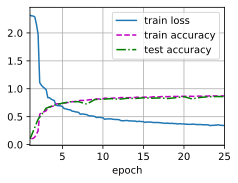

In [41]:
lr, num_epochs = 0.8, 25
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## AlexNET
* ML before NN——Learning with kernels
    * 特征提取
    * 选择核函数来计算相关性
    * 凸优化问题
    * 漂亮的定理

* 几何学 
    * 抽取特征
    * 描述几何
    * （非）凸优化
    * 漂亮定理
    * 如果假设满足和，效果很好

* 特征工程
    * 特征工程是关键
    * 特征描述子：SIFT，SURF
    * 视觉词袋（聚类）
    * 最后用SVM

* ImageNET

### AlexNet——更深更大的LeNet
* 主要改进：
    * 丢弃法——dropout
    * ReLU
    * MaxPooling
* 计算机视觉方法论的改变

* ML：人工特征提取>>SVM
* DL：通过CNN学习特征>>Softmax回归
    * 注意，深度学习本身的目的就是自动学习特征，从而减少人工的部分

### 架构
* 更大的核窗口和步长，因为图片更大了(3 * 224 * 224)
    * 11*11 Conv(96), stride 4
    * LeNet使用5*5 Conv(6)
* 更大的池化窗口，使用最大池化层
    * 3*3 MaxPool, stride 2
    * LeNet使用2*2 AvgPool, stride 2
* 更多的输出通道

![AlexNet](./imgs/alexnet.png)

#### 更多细节
* 激活函数换成了ReLU(缓解梯度消失)
* 隐藏全连接层后加入了dropout丢弃层
* 数据增强data augmentation

### 代码实现


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), 
    
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)

In [3]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 96, 54, 54])
ReLU output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([1, 96, 26, 26])
Conv2d output shape: 	 torch.Size([1, 256, 26, 26])
ReLU output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([1, 256, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 256, 12, 12])
ReLU output shape: 	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape: 	 torch.Size([1, 256, 5, 5])
Flatten output shape: 	 torch.Size([1, 6400])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output sh

In [5]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size, resize=224)

loss 0.332, train acc 0.878, test acc 0.881
132.8 examples/sec on cpu


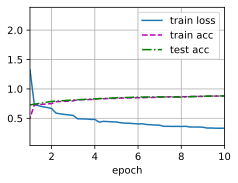

In [6]:
lr, num_epochs = 0.01, 10

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [13]:
for param in net.parameters():
    print(param.data)

tensor([[[[ 1.4802e-02, -1.1741e-02,  1.6651e-02,  ..., -1.0496e-02,
            2.0194e-02,  6.3197e-03],
          [ 6.2059e-03,  2.1033e-02,  5.0105e-03,  ...,  5.1020e-03,
           -2.5000e-03,  2.0381e-02],
          [-6.4321e-03, -1.1630e-02, -3.3423e-03,  ...,  9.7149e-03,
           -8.6646e-03, -1.7173e-02],
          ...,
          [ 1.2792e-02, -8.1366e-04,  6.6411e-03,  ...,  5.0118e-04,
           -1.2469e-02, -5.9730e-03],
          [-1.2411e-02,  1.0856e-02,  6.5850e-03,  ..., -1.2153e-02,
           -6.0542e-03,  1.0983e-03],
          [ 1.1731e-03,  2.2530e-02,  6.5993e-03,  ...,  1.1885e-02,
           -1.9169e-02,  8.2719e-04]]],


        [[[-2.3810e-03, -1.7855e-02, -1.9690e-02,  ...,  1.5479e-02,
           -2.0960e-02,  1.0730e-02],
          [-2.0868e-03, -1.1765e-02, -1.2538e-02,  ...,  4.8040e-03,
            1.6458e-02, -1.8699e-02],
          [ 1.9439e-03, -2.1265e-03, -2.9095e-02,  ..., -1.0774e-02,
            7.0226e-03, -2.0773e-02],
          ...,
   

## VGG——使用块的网络
* AlexNet比LeNet更深更大，来得到更好的精度
* 更深更大？
* 选项
    * 更多全连接层（太贵）
    * 更多的卷积层
    * 将卷积层组合成块

### VGG块
* 深但窄效果更好
* VGG块
    * 3*3卷积(填充1)
    * 2*2最大池化层

### VGG架构
* 多个VGG块后接全连接层dense
* 不同次数的重复块得到不同的架构

* VGG使用可重复使用的卷积块构建深度卷积神经网络
* 不同的卷积块个数和超参数可以得到不同复杂度的变种

In [14]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [18]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(
            vgg_block(num_convs, in_channels, out_channels)
        )
        in_channels = out_channels
        
    return nn.Sequential(
        *conv_blks, 
        nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )
    
net = vgg(conv_arch)


In [19]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape: \t', X.shape)

Sequential output shape: 	 torch.Size([1, 64, 112, 112])
Sequential output shape: 	 torch.Size([1, 128, 56, 56])
Sequential output shape: 	 torch.Size([1, 256, 28, 28])
Sequential output shape: 	 torch.Size([1, 512, 14, 14])
Sequential output shape: 	 torch.Size([1, 512, 7, 7])
Flatten output shape: 	 torch.Size([1, 25088])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 10])


In [21]:
# VGG11比AlecNet计算量还大
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

KeyboardInterrupt: 

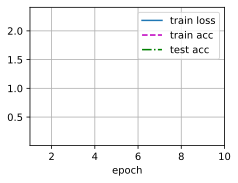

In [22]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

## NiN(network in network)

### 全连接层(dense)的问题
* 卷积层需要较少的参数，但是卷积层之后的全连接层的参数很大

### NiN：使用卷积层替换全连接层
* 一个卷积层后跟两个全连接层
    * 步幅1,无填充，输出形状跟卷积层输出一样
    * 起到全连接的作用

![Nin](./imgs/NiN.png)

### 架构
* 无全连接层
* 交替使用NiN块和步幅为2的最大池化层
    * 逐步减小高宽和增大通道数
* 最后使用全局平均池化得到输出
    * 其输出通道数是类别数

### 代码实现


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )


In [3]:
# NiN模型

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)


In [5]:
# 查看各个块的输出形状

X = torch.rand(size=(1, 1, 224, 224))
print('origin X shape: \t', X.shape)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

origin X shape: 	 torch.Size([1, 1, 224, 224])
Sequential output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([1, 96, 26, 26])
Sequential output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([1, 256, 12, 12])
Sequential output shape: 	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape: 	 torch.Size([1, 384, 5, 5])
Dropout output shape: 	 torch.Size([1, 384, 5, 5])
Sequential output shape: 	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape: 	 torch.Size([1, 10, 1, 1])
Flatten output shape: 	 torch.Size([1, 10])


training on cpu


KeyboardInterrupt: 

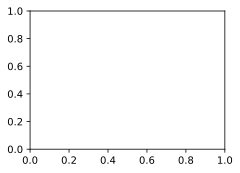

In [6]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

## GoogLeNet——含并行连接的网络
* 最好的卷积层超参数？

### Inception块——小学生才做选择题
![inception block](./imgs/inception-block1.png)
1. 1*1卷积
2. 3. 使用不同窗口大小的卷积层
4. 使用池化
* 根输入等高同宽

![inception block](./imgs/inception-block2.png)

* 根单3*3和5*5的卷积层比，Inception块有更少的参数个数和计算复杂度
### GoogleNet=5段9个Inception块


* Inception块用4条有不同超参数的卷积层和池化层来抽取不同的信息
    * 主要优点是模型参数小，计算复杂度低
* GoogleNet使用9个Inception块，是第一个达到上百层的网络

### 代码实现



In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        
    def forward(self, x):
        p1 = F.relu(
            self.p1_1(x)
        )
        p2 = F.relu(
            self.p2_2(
                F.relu(
                    self.p2_1(x)
                )
            )
        )
        p3 = F.relu(
            self.p3_2(
                F.relu(
                    self.p3_1(x)
                )
            )
        )
        p4 = F.relu(
            self.p4_2(
                self.p4_1(x)
            )
        )
        return torch.cat(
            (p1, p2, p3, p4), dim=1  #在输入通道数的维度上将p们concat起来
        )
        

In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10)) # 最后的linear是一个dense layer



In [6]:
X = torch.rand(size=(1, 1, 96, 96))
print(X.shape)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

torch.Size([1, 1, 96, 96])
Sequential output shape: 	 torch.Size([1, 64, 24, 24])
Sequential output shape: 	 torch.Size([1, 192, 12, 12])
Sequential output shape: 	 torch.Size([1, 480, 6, 6])
Sequential output shape: 	 torch.Size([1, 832, 3, 3])
Sequential output shape: 	 torch.Size([1, 1024])
Linear output shape: 	 torch.Size([1, 10])


KeyboardInterrupt: 

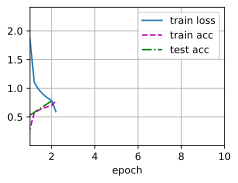

In [7]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter, = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

## Batch Normalization

* 损失出现在最后，后面的层训练较快
* 数据在最底部
    * 底部的层训练较慢
    * 底部层一变化，所有都得跟着变
    * 最后的那些层需要重新学习多次
    * 导致收敛变慢
* 我们可以在学习底部层的时候避免变化顶部层么

### 固定小批量里面的均值和方差
$$
\mu_B = \frac{1}{|B|} \Sigma_{i \in B} x_i ~ and ~ \sigma_B^2 = \frac{1}{|B|} \Sigma_{i \in B} (x_i - \mu_B)^2 + \epsilon
$$
然后再做额外的调整（可学习的参数）
$$
x_{i + 1} = \gamma \frac{x_i - \mu_B}{\sigma_B} + \beta
$$
* $\gamma$  方差
* $\beta$   均值
* 上面这俩是可学习的内容

### BN层
* 可学习的参数为\gamma和\beta
* 作用在
    * 全连接层和卷积层输出上，激活函数前
    * 全连接层和卷积层的输入上

* 对全连接层，作为在`特征维`
* 对卷积层，作用在`通道维`

### BN在做什么
* 最初论文是想用BN来减少内部协变量转移
* 后续有论文指出它可能就是通过在每个小批量里加入噪音来控制模型复杂度
    * \mu 是随机偏移
    * \sigma 是随机缩放
$$
x_{i + 1} = \gamma \frac{x_i - \hat{\mu}_B}{\hat{\sigma}_B} + \gamma
$$

* 因此没必要和Dropout丢弃法混合使用

* 批量归一化固定小批量中的均值和方差，然后学习出适合的偏移和缩放
* 可以加速收敛速度，但一般不改变模型精度

### 代码实现


In [11]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled(): # 这个用来判断是预测模式还是训练模式
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2: # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True) # 4个dim分别是(batch, num_channel, height, weight)， 对0, 2, 3都做均值
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，使用当前样本的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1. - momentum) * mean
        moving_var = momentum * moving_var + (1. - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data


# 创建一个正确的BatchNorm图层
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta =nn.Parameter(torch.zeros(shape))
        # 放在nn.Parameter中的变量，会随着Optimizer更新迭代
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, 
            eps=1e-5, momentum=0.9
        )
        return Y

In [12]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    
    nn.Linear(84, 10)
)

loss 0.234, train acc 0.914, test acc 0.879
32372.7 examples/sec on cpu


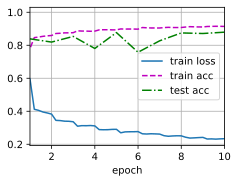

In [15]:
lr, num_epochs, batch_size = 1., 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

In [17]:
# 看一眼gamma和beta

net[1].gamma.reshape((-1, )), net[1].beta.reshape((-1, ))

(tensor([1.7193, 2.8339, 3.2123, 1.7247, 2.1179, 4.1536],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-2.0179, -0.7906,  3.9877, -0.8704,  1.1708, -4.1980],
        grad_fn=<ReshapeAliasBackward0>))

In [20]:
# 直接调包实现
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    
    nn.Linear(84, 10)
)

loss 0.251, train acc 0.907, test acc 0.831
48508.8 examples/sec on cpu


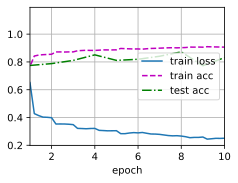

In [21]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu())

## ResNet 残差网络
* 加更多的层总是改进精度么？
![non-nested function classes](./imgs/non-nested.png)
nope
![nested function class](./imgs/nested.png)
yup

### 残差块
* 串联一个层改变函数类，希望能扩大函数类
* 残差块加入快速通道(右边)来得到f(x) = x + g(x)的结构
![res block](./imgs/res-block.png)

* 把Residual加进去可以使网络跑的很快
* 现在的网络可以允许嵌入之前的小网络，使得可以先去拟合小网络
* 实际实现的时候，快速通道是加上一个1*1的卷积层

### Residual 块
3*3 conv -> BAtch Norm -> Relu -> 3*3 Conv -> Batch Norm ->(在这里加最初的X) Relu
* 其实X也可以加在其他的位置，Conv, Batch Norm, ReLU层都可以试一试

### ResNet快
* 高宽减半ResNet块
* 后接多个高宽不变ResNet块


* 残差块使得很深的网络更加容易训练
    * 甚至可以训练一千层的网络
* 残差网络对随后的深层神经网络设计产生了深远影响，无论是卷积类网络还是全连接类网络


### 代码实现



In [ ]:
import torch
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            input_channels, num_channels, kernel_size=3, 
            padding=1, stride=strides
        )
        self.conv2 = nn.Conv2d(
            num_channels, num_channels, kernel_size=3,
            padding=1
        )
        if use1x1conv:
            self.conv3 = nn.Conv2d(
                input_channels, num_channels, 
                kernel_size=1, stride=strides
            )
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        Y = F.relu(
            self.bn1(
                self.conv1(X)
            )
        )
        Y = self.bn2(
            self.conv2(Y)
        )
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
    

In [ ]:
# 输入输出形状一致
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

In [ ]:
# 增加输出通道数的同时，减半输出的高和宽

blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

In [ ]:
# ResNet模型

b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU()
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [ ]:
# ResNet使用4个由残差块组成的模块，没个block使用若干个同样输出通道数的残差块

def resnet_block(input_channels, num_channels, 
                 num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, 
                         use_1x1conv=True, strides=2)
            )
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 128, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(
    b1, b2, b3, b4, b5, 
    nn.AdaptiveAvgPool2d((1, 1))
    nn.Flatten(),
    nn.Linear(512, 10)
)

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
print(X.shape)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


## ResNet的梯度计算——为什么可以训练1000层

## DL硬件

### 提升CPU利用率
* 再计算a+b之前，需要准备数据
    * 主内存 -> L3 -> L2 -> L1 -> 寄存器

* 提升空间和时间的内存本地性
    * 时间：重用数据使得保持它们在缓存中
    * 空间：按序读写数据使得可以预读取
* 高端CPU有几十个core
* 并行起来利用所有core
    * 超线程不一定提升性能，因为它们共享寄存器

### 提升GPU使用率
* 并行
    * 使用数千个线程
* 内存本地性
    * 缓存更小，架构更简单
* 少用控制语句
    * 支持有限
    * 同步开销很大

### CPU & GPU带宽

* 不要频繁在CPU和GPU之间传数据：带宽限制，同步开销




## 更多的芯片
### DSP 数字信号处理
* 为数字信号处理算法设计：点积，卷积，FFT
* 低功耗，高性能
    * 比移动GPU快5x，功耗更低
* VLIW：very long instruction word
    * 一条指令计算上百次乘累加
* 编程和调试困难
* 良莠不齐
### 可编程阵列FPGA
* 有大量可编程逻辑单元和课配置的连接
### AI ASIC
* DL
* Google TPU是标志性芯片
    * 核心是systolic array
### 

## 单机多卡并行
* 一台机器可以安装多个GPU
* 在训练和预测时，将一个小批量计算切分到多个GPU上来达到加速目的
* 常用切分方案
    * 数据并行
    * 模型并行
    * 通道并行（数据+模型并行）

### 数据并行vs模型并行
* 数据并行：将小批量分成n块，每个GPU拿到完整参数计算一块数据的梯度
    * 通常性能更好
* 模型并行：将模型分成n块，每个GPU拿到一块模型计算它的前向和方向结果
    * 通常用于模型大到单GPU放不下

### 代码实现

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as torch

In [ ]:
# 使用LeNet进行实验

scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)

params = [W1, b1, W2, b2, W3, b3, W4, b4]

def lenet(X, params):
    h1 = F.avg_pool2d(
        F.relu(
            F.conv2d(
                input=X, weight=params[0], bias=params[1]
            )
        )
    )
    h2 = F.avg_pool2d(
        F.relu(
            F.conv2d(
                input=h1, weight=params[2], bias=params[3]
            )
        )        
    )
    h2 = h2.reshape(h2.shape[0], -1)
    h3 = F.relu(
        torch.mm(h2, params[4]) + param[5]
    )
    return torch.mm(h3, params[6] + params[7])

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')


In [ ]:
# 向多个设备分发参数

def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad__()
    return new_params


new_params = get_params(params, d2l.try_gpu(0))
print('bi weight: ', new_params[1])
print('bi grad: ', new_params[1].grad)


# allreduce将所有向量相加，并将结果广播给所有GPU
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

# 通过在不同设备上创建具有不同值的向量并聚合
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce: ', data[0], '\n', data[1])
allreduce(data)
print('after allreduce: ', data[0], '\n', data[1])

